In [1]:
import asf_search as asf
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np
import boto3
import geopandas as gpd
import contextily as ctx
from shapely.geometry import box, shape
import datetime
from rasterio.crs import CRS
import pandas as pd
import requests
from zipfile import ZipFile
from io import BytesIO
from rasterio.io import MemoryFile
import rasterio
from rasterio.session import AWSSession
from sklearn.metrics import precision_recall_fscore_support as score
from tqdm import tqdm

# AWS Session

In [2]:
session = boto3.session.Session(profile_name='saml-pub')
s3 = session.resource('s3')

# Get Validation Datasets

In [3]:
obj = s3.Object('calval-metadata', 'test-prod--water-class-from-2020-hansen-landsat.geojson')
obj.get()

{'ResponseMetadata': {'RequestId': '2VY5YTVQNN59ZYDN',
  'HostId': 'OpZIGkXH0VlhpddmWKCiLE6vAY8oWcCwCPIasP3dgUDnarQxNn+Kwfv/cDLD87Rl2j7F1N0qZwI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'OpZIGkXH0VlhpddmWKCiLE6vAY8oWcCwCPIasP3dgUDnarQxNn+Kwfv/cDLD87Rl2j7F1N0qZwI=',
   'x-amz-request-id': '2VY5YTVQNN59ZYDN',
   'date': 'Tue, 04 Jan 2022 21:18:40 GMT',
   'last-modified': 'Mon, 03 Jan 2022 22:23:53 GMT',
   'etag': '"0b429c65865dbbfb282659956a6d1c86"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '1137'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2022, 1, 3, 22, 23, 53, tzinfo=tzutc()),
 'ContentLength': 1137,
 'ETag': '"0b429c65865dbbfb282659956a6d1c86"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7fc5e704efe0>}

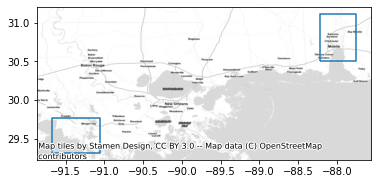

In [4]:
fig, ax = plt.subplots()

data = obj.get()['Body']
df_val = gpd.read_file(data)

df_val.exterior.plot(ax=ax, zorder=1)
ctx.add_basemap(ax, crs=df_val.crs, source=ctx.providers.Stamen.TonerLite)

# Get ALOS-1 Data (proxy for OPERA products)

Using the `asf-search` api.

In [5]:
df_val.bounds

,minx,miny,maxx,maxy
0,-91.678271,29.320519,-91.060147,29.773093
1,-88.215914,30.503890,-87.749824,31.112927


In [6]:
K = 0
bounds = df_val.bounds.iloc[K]

box_geo = box(*bounds)
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2011, 1, 1)

results = asf.geo_search(intersectsWith=box_geo.wkt,
                         start=start,
                         end=end,
                         maxResults=100,
                         # Finebeam Dual
                         beamMode=[asf.FBD],
                         # RTC low res
                         processingLevel=asf.RTC_LOW_RES,
                        )
df = pd.DataFrame([r.properties for r in results])
df.head()

,beamModeType,browse,bytes,faradayRotation,fileID,fileName,flightDirection,frameNumber,granuleType,groupID,...,platform,pointingAngle,polarization,processingDate,processingLevel,sceneName,sensor,startTime,stopTime,url
0,FBD,[https://datapool.asf.alaska.edu/BROWSE/A3/ALP...,66592384,5.102756,ALPSRP259520580-RTC_LOW_RES,AP_25952_FBD_F0580_RT2.zip,ASCENDING,580,ALOS_PALSAR_SCENE,None,...,ALOS,None,HH+HV,2015-01-26T13:54:48Z,RTC_LOW_RES,ALPSRP259520580,PALSAR,2010-12-08T04:35:24Z,2010-12-08T04:35:28Z,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...
1,FBD,[https://datapool.asf.alaska.edu/BROWSE/A3/ALP...,65009851.0,5.072044,ALPSRP259520570-RTC_LOW_RES,AP_25952_FBD_F0570_RT2.zip,ASCENDING,570,ALOS_PALSAR_SCENE,None,...,ALOS,None,HH+HV,2015-01-26T13:54:51Z,RTC_LOW_RES,ALPSRP259520570,PALSAR,2010-12-08T04:35:15Z,2010-12-08T04:35:20Z,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...
2,FBD,[https://datapool.asf.alaska.edu/BROWSE/A3/ALP...,67613003.0,3.836275,ALPSRP257040580-RTC_LOW_RES,AP_25704_FBD_F0580_RT2.zip,ASCENDING,580,ALOS_PALSAR_SCENE,ALPSRP257040580,...,ALOS,None,HH+HV,2015-01-25T16:32:28Z,RTC_LOW_RES,ALPSRP257040580,PALSAR,2010-11-21T04:33:33Z,2010-11-21T04:33:37Z,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...
3,FBD,[https://datapool.asf.alaska.edu/BROWSE/A3/ALP...,66312798.0,3.829205,ALPSRP257040570-RTC_LOW_RES,AP_25704_FBD_F0570_RT2.zip,ASCENDING,570,ALOS_PALSAR_SCENE,ALPSRP257040570,...,ALOS,None,HH+HV,2015-01-25T16:11:36Z,RTC_LOW_RES,ALPSRP257040570,PALSAR,2010-11-21T04:33:25Z,2010-11-21T04:33:29Z,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...
4,FBD,[https://datapool.asf.alaska.edu/BROWSE/A3/ALP...,66628700.0,4.011633,ALPSRP252810580-RTC_LOW_RES,AP_25281_FBD_F0580_RT2.zip,ASCENDING,580,ALOS_PALSAR_SCENE,ALPSRP252810580,...,ALOS,None,HH+HV,2015-01-24T04:47:27Z,RTC_LOW_RES,ALPSRP252810580,PALSAR,2010-10-23T04:36:10Z,2010-10-23T04:36:14Z,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...


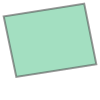

In [7]:
geometry = [shape(r.geometry) for r in results]
geometry[0]

In [8]:
geometry = [shape(r.geometry) for r in results]

df_alos = gpd.GeoDataFrame(df,
                           geometry=geometry,
                           crs=CRS.from_epsg(4326))

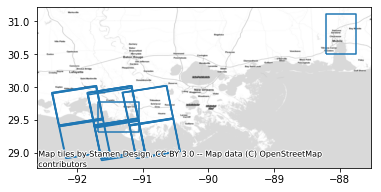

In [9]:
fig, ax = plt.subplots()


df_val.exterior.plot(ax=ax, zorder=2)
df_alos.exterior.plot(ax=ax, zorder=1)
ctx.add_basemap(ax, crs=df_val.crs, source=ctx.providers.Stamen.TonerLite)

In [10]:
val_geo = df_val.geometry[K]
PERCENT_OVERLAP = .25

df_alos['intersection'] = df_alos.geometry.intersection(val_geo).area / df_alos.geometry.area
df_alos_f = df_alos[df_alos['intersection'] > PERCENT_OVERLAP].reset_index(drop=True)

/tmp/ipykernel_325471/2576959409.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_alos['intersection'] = df_alos.geometry.intersection(val_geo).area / df_alos.geometry.area


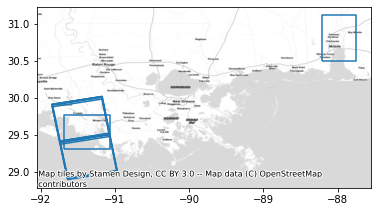

In [11]:
fig, ax = plt.subplots()


df_val.exterior.plot(ax=ax, zorder=2)
df_alos_f.exterior.plot(ax=ax, zorder=1)
ctx.add_basemap(ax, crs=df_val.crs, source=ctx.providers.Stamen.TonerLite)

In [12]:
df_alos_f.url.tolist()

['https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_25952_FBD_F0580_RT2.zip',
 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_25952_FBD_F0570_RT2.zip',
 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_25281_FBD_F0580_RT2.zip',
 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_25281_FBD_F0570_RT2.zip',
 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_24610_FBD_F0580_RT2.zip',
 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_23939_FBD_F0580_RT2.zip',
 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_23939_FBD_F0570_RT2.zip',
 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_23268_FBD_F0580_RT2.zip',
 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_23268_FBD_F0570_RT2.zip']

## Read ALOS data and simple water mask

Source: https://stackoverflow.com/a/10909016

In [13]:
url = 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_25952_FBD_F0580_RT2.zip'

resp = requests.get(url)
input_zip=ZipFile(BytesIO(resp.content))
input_zip.namelist()

['AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2.dem.tif',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2.ls_map.tif',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2.inc_map.tif',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2.kmz',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2.iso.xml',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2.geo.jpg',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2.geo.jpg.aux.xml',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2.geo.wld',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2_HH.tif',
 'AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2_HV.tif']

In [14]:
data = input_zip.read('AP_25952_FBD_F0580_RT2/AP_25952_FBD_F0580_RT2_HV.tif')

with MemoryFile(data) as memfile:
    with memfile.open() as ds:
        hv = ds.read(1)
        hv_profile = ds.profile
        
hv_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2654, 'height': 2343, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(30.0, 0.0, 611018.3125,
       0.0, -30.0, 3323843.0), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

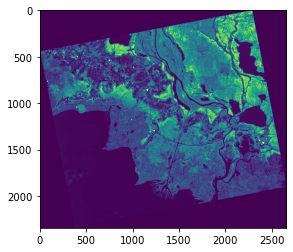

In [15]:
plt.imshow(hv, vmin=0, vmax=.15)

## Simple Water Mask (poor proxy)


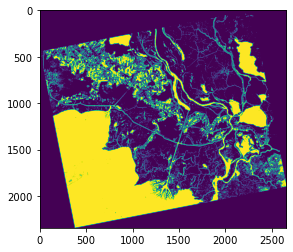

In [16]:
nodata_mask = (hv == 0)

hv_db = 10 * np.log10(hv, where=~nodata_mask)
water_mask = (hv_db < -18)

plt.imshow(water_mask)

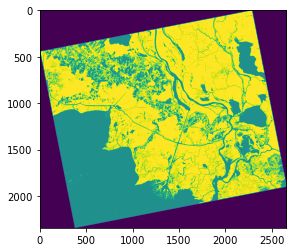

In [17]:
class_arr_alos = np.zeros(water_mask.shape)

class_arr_alos[water_mask & ~nodata_mask] = 1
class_arr_alos[~water_mask & ~nodata_mask] = 2

plt.imshow(class_arr_alos)

## Compare ALOS-1 Water Mask with Validation Dataset

In [18]:
val_records = df_val.to_dict('records')
val_record = val_records[K]
val_record

{'bucket': 'test-prod--water-class-from-2020-hansen-landsat',
 'key': 'Hansen_GFC-2020-v1.8_last_30N_100W.tif',
 'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
 'year': 2020,
 'geometry': <shapely.geometry.polygon.Polygon at 0x7fc5e6ef9b40>}

In [19]:
bucket = val_record['bucket']
key = val_record['key']

with rasterio.Env(AWSSession(session)):
    with rasterio.open(f's3://{bucket}/{key}') as ds:
        val_profile = ds.profile
        val_img = ds.read()
        
val_profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2473, 'height': 1810, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -91.6785,
       0.0, -0.00025, 29.77325), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [20]:
val_img_r, prof_r = reproject_arr_to_match_profile(val_img, val_profile, hv_profile, resampling='bilinear')
val_img_r = val_img_r[0, ...]

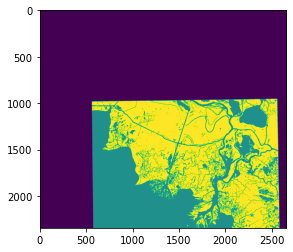

In [21]:
plt.imshow(val_img_r)

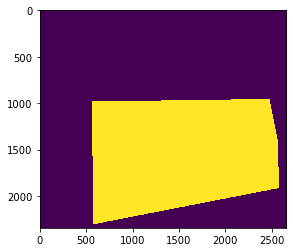

In [22]:
data_mask = ~nodata_mask.astype(bool) & np.isin(val_img_r, [1, 2])
plt.imshow(data_mask, interpolation='none')

In [23]:
y_val = val_img_r[data_mask]
y_alos = class_arr_alos[data_mask]

In [24]:
class2label = {'water': 1, 'land': 2}
label2class = {v: k for k, v in class2label.items()}

In [25]:
y_true_str = pd.Series([label2class[class_id] for class_id in y_val], name='Validation')
y_pred_str = pd.Series([label2class[class_id] for class_id in y_alos], name='Product')
y_pred_str[:5]

0    land
1    land
2    land
3    land
4    land
Name: Product, dtype: object

In [26]:
df = pd.crosstab(y_true_str, y_pred_str)
df

Product,land,water
Validation,,
land,1140662,132191
water,150215,832583


In [27]:
precision, recall, fscore, support = score(y_val, y_alos, labels=[2, 1])

In [28]:
index = df.index
df_scores = pd.DataFrame({'Producer': precision,
                          'User': recall,
                         },
                         index = index)
df_scores

,Producer,User
Validation,,
land,0.883633,0.896146
water,0.862982,0.847156


# Automate Comparison

In [29]:
import warnings

def read_alos_hv_image(alos_url):
    resp = requests.get(alos_url)
    input_zip=ZipFile(BytesIO(resp.content))
    hv_filename = [name for name in input_zip.namelist() if '_HV' in name][0]
    
    data = input_zip.read(hv_filename)
    with MemoryFile(data) as memfile:
        with memfile.open() as ds:
            hv = ds.read(1)
            hv_profile = ds.profile
    return hv, hv_profile

def get_water_mask(hv_img):
    nodata_mask = (hv_img <= 0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        hv_db = 10 * np.log10(hv_img, where=~nodata_mask)
    water_mask = (hv_db < -18)
    
    class_arr_alos = np.zeros(water_mask.shape)
    class_arr_alos[water_mask & ~nodata_mask] = 1
    class_arr_alos[~water_mask & ~nodata_mask] = 2
    
    return class_arr_alos

def read_validation_image(val_record):
    bucket = val_record['bucket']
    key = val_record['key']
    with rasterio.Env(AWSSession(session)):
        with rasterio.open(f's3://{bucket}/{key}') as ds:
            val_profile = ds.profile
            val_img = ds.read(1)
        
    return val_img, val_profile

def get_comp_stats(val_img, val_prof, class_img, class_profile):
    
    val_img_r, prof_r = reproject_arr_to_match_profile(val_img, 
                                                       val_prof, 
                                                       class_profile, 
                                                       resampling='bilinear')
    val_img_r = val_img_r[0, ...]
    data_mask = np.isin(val_img_r, [1., 2.]) & (class_img != 0)
    
    y_val = val_img_r[data_mask]
    y_alos = class_img[data_mask]
    
    perc_pixels = y_alos.size / class_img[class_img != 0].size
    
    labels = [2, 1]
    
    accuracy = np.sum(y_val == y_alos) / y_alos.shape[0]
    precision, recall, fscore, support = score(y_val, y_alos, labels=labels)
    
    return {'precision': precision,
            'recall': recall,
            'fscore': fscore,
            'accuracy': accuracy,
            'labels': labels,
            'total_pixels_used': y_val.shape[0],
            'percent_of_alos_pixels': perc_pixels}

def get_alos_prods(val_record, percent_overlap=.25):
    box_geo = box(*val_record['geometry'].bounds)
    start = datetime.datetime(2010, 1, 1)
    end = datetime.datetime(2011, 1, 1)

    results = asf.geo_search(intersectsWith=box_geo.wkt,
                             start=start,
                             end=end,
                             maxResults=100,
                             # Finebeam Dual
                             beamMode=[asf.FBD],
                             # RTC low res
                             processingLevel=asf.RTC_LOW_RES,
                            )
    df = pd.DataFrame([r.properties for r in results])
    geometry = [shape(r.geometry) for r in results]

    df_alos = gpd.GeoDataFrame(df,
                               geometry=geometry,
                               crs=CRS.from_epsg(4326))
    
    val_geo = val_record['geometry']
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        df_alos['intersection'] = df_alos.geometry.intersection(val_geo).area / df_alos.geometry.area
    df_alos_f = df_alos[df_alos['intersection'] > percent_overlap].reset_index(drop=True)
    return df_alos_f


def compare_one_val_and_prod(val_record, alos_url):
    hv_img, hv_profile = read_alos_hv_image(alos_url)
    val_img, val_profile = read_validation_image(val_record)
    class_arr = get_water_mask(hv_img)
    
    data = get_comp_stats(val_img, val_profile, class_arr, hv_profile)
    data['alos_url'] = alos_url
    data.update(val_record)
    for key in ['bucket', 'key']:
        data[('val_' + key)] = data.pop(key)

    return data

def validate_products_one_record(val_record):
    df_alos = df = get_alos_prods(val_record)
    urls = df_alos.url.tolist()
    
    def compare_one_val_and_prod_part(alos_url):
        return compare_one_val_and_prod(val_record, alos_url)
    
    results = list(map(compare_one_val_and_prod_part, tqdm(urls, desc='alos comps')))
    return results

def validate_products_all_records(val_records):
    temp_r = list(map(validate_products_one_record, tqdm(val_records, desc=f'val_records')))
    results = [item for r in temp_r for item in r ]
    return results

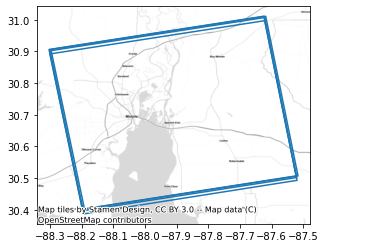

In [30]:
fig, ax = plt.subplots()

val_record = val_records[1]
df = get_alos_prods(val_record)

df.exterior.plot(ax=ax)
ctx.add_basemap(ax, crs=df.crs, source=ctx.providers.Stamen.TonerLite)


In [31]:
urls = df.url.tolist()
X, p = read_alos_hv_image(urls[0])

Y, q = read_validation_image(val_record)

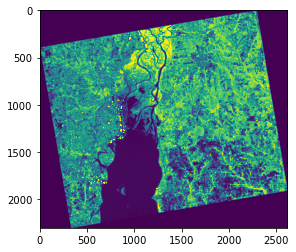

In [32]:
plt.imshow(X, vmin=0, vmax=.1)

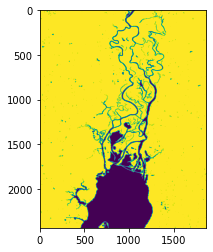

In [33]:
plt.imshow(Y)

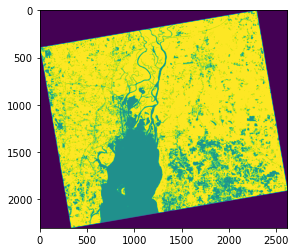

In [34]:
class_arr = get_water_mask(X)
plt.imshow(class_arr)

In [35]:
data = get_comp_stats(Y, q, class_arr, p)
data

{'precision': array([0.98397226, 0.63115477]),
 'recall': array([0.87997439, 0.93476281]),
 'fscore': array([0.92907208, 0.75352625]),
 'accuracy': 0.8898438617401668,
 'labels': [2, 1],
 'total_pixels_used': 2517000,
 'percent_of_alos_pixels': 0.562129113709764}

In [36]:
comp_data = compare_one_val_and_prod(val_record, df.url[0])
comp_data

{'precision': array([0.98397226, 0.63115477]),
 'recall': array([0.87997439, 0.93476281]),
 'fscore': array([0.92907208, 0.75352625]),
 'accuracy': 0.8898438617401668,
 'labels': [2, 1],
 'total_pixels_used': 2517000,
 'percent_of_alos_pixels': 0.562129113709764,
 'alos_url': 'https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_25558_FBD_F0600_RT2.zip',
 'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif',
 'year': 2020,
 'geometry': <shapely.geometry.polygon.Polygon at 0x7fc5e6ef9ae0>,
 'val_bucket': 'test-prod--water-class-from-2020-hansen-landsat',
 'val_key': 'Hansen_GFC-2020-v1.8_last_40N_090W.tif'}

In [37]:
# results = validate_products_one_record(val_record)
# results

In [38]:
results = validate_products_all_records(val_records)

val_records: 100%|████████████████████████████████| 2/2 [02:45<00:00, 82.61s/it]


(array([1., 0., 2., 1., 1., 3., 2., 1., 1., 1.]),
 array([0.86642834, 0.87035201, 0.87427568, 0.87819935, 0.88212302,
        0.88604668, 0.88997035, 0.89389402, 0.89781769, 0.90174136,
        0.90566503]),
 <BarContainer object of 10 artists>)

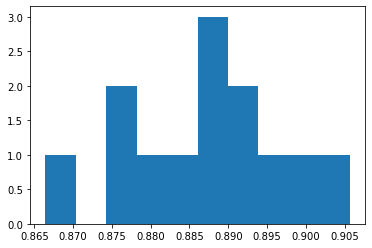

In [39]:
df_results = pd.DataFrame(results)

plt.hist(df_results.accuracy)

In [40]:
df_results.head()

,precision,recall,fscore,accuracy,labels,total_pixels_used,percent_of_alos_pixels,alos_url,source_url,year,geometry,val_bucket,val_key
0,"[0.8836333748296701, 0.8629824186804371]","[0.8961459021583796, 0.847155773617773]","[0.8898456545736095, 0.8549958615137206]",0.874801,"[2, 1]",2255651,0.503396,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.678270890115 29.320518966016902,...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif
1,"[0.8151642076399632, 0.937953952372725]","[0.8241727497011471, 0.9343103706468607]","[0.8196437266420887, 0.9361286161536085]",0.905665,"[2, 1]",1209350,0.269891,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.678270890115 29.320518966016902,...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif
2,"[0.8886177751949171, 0.8615871244599977]","[0.8940821900605909, 0.8547186647551818]","[0.8913416077384271, 0.8581391512120324]",0.876941,"[2, 1]",2256951,0.503777,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.678270890115 29.320518966016902,...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif
3,"[0.8225912942858116, 0.9222615188025225]","[0.7723564505769458, 0.9419045517462737]","[0.7966827682931452, 0.9319795442954223]",0.898063,"[2, 1]",1210223,0.270133,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.678270890115 29.320518966016902,...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif
4,"[0.8867544602437922, 0.8765058656425904]","[0.9073752574553546, 0.8501476654169022]","[0.8969463564711095, 0.863125580200252]",0.882420,"[2, 1]",2247128,0.501591,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.678270890115 29.320518966016902,...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif


In [41]:
def format_results(df):
    df_new = df.copy()
    for col in ['precision', 'recall', 'fscore', 'labels']:
        df_new[col] = df_new[col].map(lambda data: ','.join([str(d) for d in data]))
    df_new = gpd.GeoDataFrame(df_new,
                              geometry=df_new.geometry,
                              crs=CRS.from_epsg(4326))
    df_new['bucket'] = 'test-prod--validation_results'
    df_new['key'] = ''
    return df_new
    
df_results_final = format_results(df_results)
df_results_final.head()

,precision,recall,fscore,accuracy,labels,total_pixels_used,percent_of_alos_pixels,alos_url,source_url,year,geometry,val_bucket,val_key,bucket,key
0,"0.8836333748296701,0.8629824186804371","0.8961459021583796,0.847155773617773","0.8898456545736095,0.8549958615137206",0.874801,"2,1",2255651,0.503396,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.67827 29.32052, -91.06015 29.320...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif,test-prod--validation_results,
1,"0.8151642076399632,0.937953952372725","0.8241727497011471,0.9343103706468607","0.8196437266420887,0.9361286161536085",0.905665,"2,1",1209350,0.269891,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.67827 29.32052, -91.06015 29.320...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif,test-prod--validation_results,
2,"0.8886177751949171,0.8615871244599977","0.8940821900605909,0.8547186647551818","0.8913416077384271,0.8581391512120324",0.876941,"2,1",2256951,0.503777,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.67827 29.32052, -91.06015 29.320...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif,test-prod--validation_results,
3,"0.8225912942858116,0.9222615188025225","0.7723564505769458,0.9419045517462737","0.7966827682931452,0.9319795442954223",0.898063,"2,1",1210223,0.270133,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.67827 29.32052, -91.06015 29.320...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif,test-prod--validation_results,
4,"0.8867544602437922,0.8765058656425904","0.9073752574553546,0.8501476654169022","0.8969463564711095,0.863125580200252",0.882420,"2,1",2247128,0.501591,https://datapool.asf.alaska.edu/RTC_LOW_RES/A3...,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.67827 29.32052, -91.06015 29.320...",test-prod--water-class-from-2020-hansen-landsat,Hansen_GFC-2020-v1.8_last_30N_100W.tif,test-prod--validation_results,


In [42]:
df_results_final.to_file('test-prod--validation_results.geojson', driver='GeoJSON')

# Record Comparison

In [43]:
geojson_bytes = bytes(df_results_final.to_json(drop_id=True).encode('UTF-8'))

geojson_bucket = 'calval-metadata'
geojson_key = f'{df_results_final.bucket[0]}.geojson'

s3object = s3.Object(geojson_bucket, geojson_key)
s3object.put(Body=geojson_bytes)

{'ResponseMetadata': {'RequestId': 'Z45Q7615PQ1V5YDP',
  'HostId': 'wdu8tl9FG4JB1cF13PETE76mw+l1dvu72Q+mc1k8e/8UcAPpeF1AzOglIFhkqAmvm+ycRzBoAvY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'wdu8tl9FG4JB1cF13PETE76mw+l1dvu72Q+mc1k8e/8UcAPpeF1AzOglIFhkqAmvm+ycRzBoAvY=',
   'x-amz-request-id': 'Z45Q7615PQ1V5YDP',
   'date': 'Tue, 04 Jan 2022 21:22:25 GMT',
   'etag': '"718dd43b3601e35588e77d83e90deb32"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"718dd43b3601e35588e77d83e90deb32"'}